In [1]:
import utils
import matplotlib.pyplot as plt
import pandas as pd

data, _ = utils.load_data()

In [2]:
alerts = utils.extract_event(data, ['ACCIDENT']).drop("uuid", axis=1)

In [3]:
antof_grid = utils.grid(alerts, 10, 20)
antof_grid

(array([[-7838254.59109428, -7837788.59533698, -7837322.59957969,
         -7836856.6038224 , -7836390.60806511, -7835924.61230781,
         -7835458.61655052, -7834992.62079323, -7834526.62503594,
         -7834060.62927864],
        [-7838254.59109428, -7837788.59533698, -7837322.59957969,
         -7836856.6038224 , -7836390.60806511, -7835924.61230781,
         -7835458.61655052, -7834992.62079323, -7834526.62503594,
         -7834060.62927864],
        [-7838254.59109428, -7837788.59533698, -7837322.59957969,
         -7836856.6038224 , -7836390.60806511, -7835924.61230781,
         -7835458.61655052, -7834992.62079323, -7834526.62503594,
         -7834060.62927864],
        [-7838254.59109428, -7837788.59533698, -7837322.59957969,
         -7836856.6038224 , -7836390.60806511, -7835924.61230781,
         -7835458.61655052, -7834992.62079323, -7834526.62503594,
         -7834060.62927864],
        [-7838254.59109428, -7837788.59533698, -7837322.59957969,
         -7836856.6038224 

In [4]:
alerts_grouped = alerts.copy()
alerts_grouped["group"] = alerts_grouped.to_crs(epsg=3857).geometry.apply(
    lambda x: utils.get_quadrant(
        *antof_grid,
        (
            x.x,
            x.y,
        ),
    ),
)   

In [5]:
alerts_grouped["group"].value_counts()

group
132    79
48     36
141    32
159    29
149    27
       ..
23      1
151     1
126     1
13      1
32      1
Name: count, Length: 92, dtype: int64

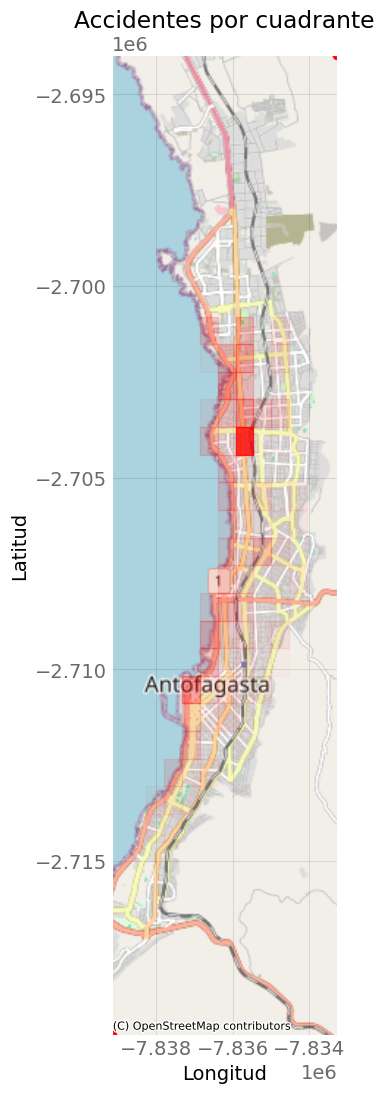

In [6]:
ax = utils.plot_antof()
# ax.plot(*antof_grid, marker="o", color="r", ls="None", markersize=3)
xc, yc = utils.get_center_points(antof_grid)
i, j = 0, 0
between_x = xc[0][1] - xc[0][0]
between_y = yc[1][0] - yc[0][0]
for xp in xc[0]:
    for yp in yc.T[0]:
        quad = utils.calc_quadrant(i, j, antof_grid[0].shape[1] - 1)
        # ax.text(xp - 150, yp - 150, quad, fontsize=6, alpha=0.5)
        xf = xp - between_x / 2
        yf = yp - between_y / 2

        ax.fill_between(
            [xf, xf + between_x],
            yf,
            yf + between_y,
            alpha=(
                (
                    alerts_grouped["group"].value_counts()[
                        quad
                        if quad in alerts_grouped["group"].value_counts().index
                        else alerts_grouped["group"].value_counts().idxmin()
                    ]
                    - alerts_grouped["group"].value_counts().min()
                )
                / (
                    alerts_grouped["group"].value_counts().max()
                    - alerts_grouped["group"].value_counts().min()
                )
            ) * 0.8,
            color="r"
        )
        j += 1
    i += 1
    j = 0

plt.title("Accidentes por cuadrante")
plt.ylabel("Latitud")
plt.xlabel("Longitud")
plt.show()

In [7]:
alerts_grouped

,street,inicio,fin,x,y,geometry,hour,minute,day,week_day,day_type,group
4,Irarrázaval,2024-08-23 11:12:19-04:00,2024-08-23 14:58:45-04:00,-70.385121,-23.603942,POINT (-7835235.829 -2705220.449),11,12,23,4,s,115
88,Díaz Gana,2024-08-23 14:34:02-04:00,2024-08-23 14:58:45-04:00,-70.403283,-23.665486,POINT (-7837257.614 -2712698.778),14,34,23,4,s,21
89,Av. Angamos,2024-08-23 14:33:40-04:00,2024-08-23 14:58:45-04:00,-70.403216,-23.665352,POINT (-7837250.155 -2712682.492),14,33,23,4,s,21
96,Av. Edmundo Pérez Zujovic,2024-08-23 14:43:35-04:00,2024-08-23 14:58:45-04:00,-70.396410,-23.628191,POINT (-7836492.515 -2708166.572),14,43,23,4,s,76
101,Av. Grecia,2024-08-23 15:29:55-04:00,2024-08-23 14:58:45-04:00,-70.402631,-23.654842,POINT (-7837185.033 -2711405.154),15,29,23,4,s,39
...,...,...,...,...,...,...,...,...,...,...,...,...
11114,Antonio José de Sucre,2024-10-12 17:17:07-03:00,2024-10-10 23:34:44-03:00,-70.398307,-23.645190,POINT (-7836703.688 -2710232.184),17,17,12,5,f,49
11131,Av. Antonio Rendic,2024-10-12 17:55:14-03:00,2024-10-10 23:34:44-03:00,-70.388855,-23.638849,POINT (-7835651.496 -2709461.634),17,55,12,5,f,60
11162,Acceso Playa Paraíso,2024-10-12 18:49:11-03:00,2024-10-10 23:34:44-03:00,-70.396765,-23.638764,POINT (-7836532.033 -2709451.305),18,49,12,5,f,67
11176,Av. Angamos,2024-10-12 19:12:38-03:00,2024-10-10 23:34:44-03:00,-70.410713,-23.679989,POINT (-7838084.718 -2714461.578),19,12,12,5,f,1


In [22]:
alerts_cleaned = alerts_grouped.drop(["street", "inicio", "fin", "x", "y", "geometry", "day"], axis=1)
results = utils.xgb_classifier(alerts_cleaned, "happen", ohe=False)

[0.78362573 0.84210526 0.8245614  0.83040936 0.65497076 0.8245614
 0.84117647 0.78823529 0.87647059 0.78823529]
0.805435156518748


In [23]:
xgb = results["model"]

In [24]:
xgb.predict(results["X_test"])

array([1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1,

In [25]:
results["X_train"]

,hour,minute,week_day,day_type,group
7628,15,22,0,1,41
696,5,35,0,1,70
5727,13,52,3,0,96
5748,22,55,3,0,170
4,13,44,3,0,114
...,...,...,...,...,...
277,7,9,0,1,5
441,20,49,2,1,33
7,3,41,1,0,77
606,19,13,2,1,105


In [29]:
day_type = 1
hour = 7
minute = 30
week_day = 3
group = 76

In [30]:
# Preparing a sample with the same structure as X_train_happen
obj = pd.DataFrame(columns=results["X_train"].columns)
obj.loc[0] = 0  # Initialize all values to 0

probs = []

# Set desired features
obj["day_type"] = day_type
obj["hour"] = hour
obj["minute"] = minute
obj["week_day"] = week_day
obj["group"] = group

prob_happen = xgb.predict_proba(obj)
prob_happen


array([[0.35465443, 0.64534557]], dtype=float32)

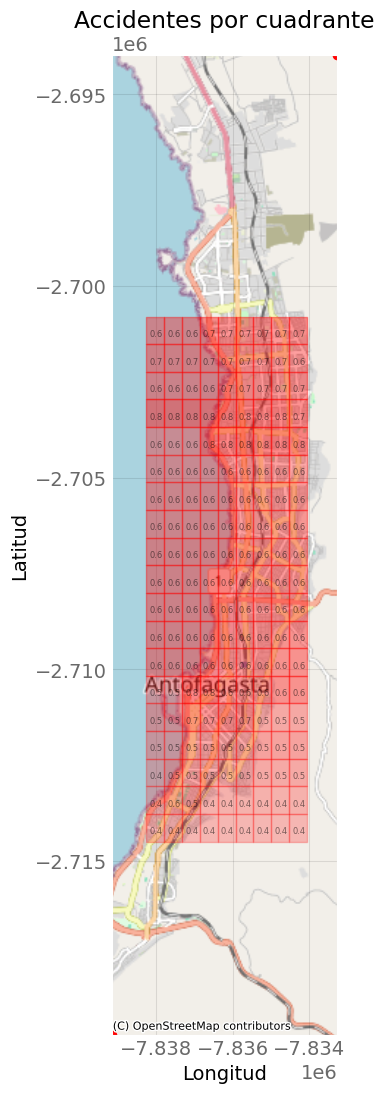

In [31]:
ax = utils.plot_antof()
xc, yc = utils.get_center_points(antof_grid)
i, j = 0, 0
between_x = xc[0][1] - xc[0][0]
between_y = yc[1][0] - yc[0][0]
for xp in xc[0]:
    for yp in yc.T[0]:
        quad = utils.calc_quadrant(i, j, antof_grid[0].shape[1] - 1)
        xf = xp - between_x / 2
        yf = yp - between_y / 2
        obj["group"] = quad
        pred = xgb.predict_proba(obj)[0][1]
        ax.text(xp - 150, yp - 150, round(pred, 1), fontsize=6, alpha=0.5)
        ax.fill_between(
            [xf, xf + between_x],
            yf,
            yf + between_y,
            alpha=pred*0.6,
            color="r",
        )
        j += 1
    i += 1
    j = 0

plt.title("Accidentes por cuadrante")
plt.ylabel("Latitud")
plt.xlabel("Longitud")
plt.show()
    